In [14]:
import numpy as np
from numpy import genfromtxt

import csv
import os

import deepSI
from deepSI import System_data

import pysindy as ps
from pysindy import SINDy

from torch import nn
import torch

import matplotlib.pyplot as plt

from scipy.io import loadmat

from deepSI.utils import simple_res_net, feed_forward_nn

from utils import SINDy_model, center, NRMS

In [15]:
save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"
save_dir = os.path.join(save_dir,'SilverboxFiles')
out = loadmat(os.path.join(save_dir,'SNLS80mV.mat'))

u, y = out['V1'][0], out['V2'][0]

train, test = System_data(u=u[40000:],y=y[40000:]), System_data(u=u[:40000],y=y[:40000])

In [16]:
# y_out = train.y[1:]
# y_in = train.y[:-1]

# y_fun = gen_Theta(y_in)

In [17]:
class base_encoder_net(nn.Module):
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(base_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod(self.ny,dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)
    
class base_state_net(nn.Module):
    def __init__(self, nx, nu, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(base_state_net, self).__init__()
        from deepSI.utils import simple_res_net
        
        nu = 1 if nu==None else nu
        self.nu = nu
        self.nx = nx

        self.net = simple_res_net(n_in=self.nx+self.nu, \
            n_out=self.nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)
    
class identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def forward(self, input):
        return input[:,-1]

In [18]:

fit_sys_ss_enc = deepSI.load_system(r'C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\models\H_identity')

In [19]:
y_mu  = fit_sys_ss_enc.norm.y0
y_std = fit_sys_ss_enc.norm.ystd

In [20]:
test_sim_enc = fit_sys_ss_enc.apply_experiment(test, save_state=True)
train_sim_enc = fit_sys_ss_enc.apply_experiment(train, save_state=True)
x_train = train_sim_enc.x*y_std - y_mu
x_test = test_sim_enc.x*y_std - y_mu

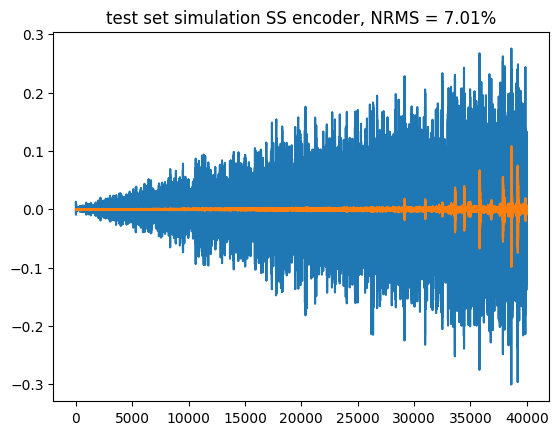

In [21]:
plt.plot(test.y)
plt.plot(test.y - test_sim_enc.y)
plt.title(f'test set simulation SS encoder, NRMS = {test_sim_enc.NRMS(test):.2%}')
plt.show()

In [22]:
fs = 610.35
dt = 1/fs

model = SINDy_model(
  x_data=x_train,
  u_data=train.u,
  x_test=x_test, # if not specified will use data_split to create test set
  u_test=test.u,
  data_split=None, # percentage of x_data/u_data that will be used for testing
  discrete_time=True,
  t_default=dt,
  feature_library=ps.PolynomialLibrary(degree=3),
  optimizer=ps.STLSQ(alpha=500, threshold=0.0001)
)

model.fit_s()
model.print()
predicted = model.predict_s()
simulated = model.simulate_s()

(x0)[k+1] = 0.017 1 + -0.090 x0[k] + -0.884 x1[k] + -0.042 u0[k] + 0.012 x0[k]^2 + -0.190 x0[k] x1[k] + 0.006 x0[k] u0[k] + -0.160 x1[k]^2 + -0.039 x1[k] u0[k] + -0.063 u0[k]^2 + -3.151 x0[k]^3 + -5.101 x0[k]^2 x1[k] + -5.055 x0[k] x1[k]^2 + -2.085 x1[k]^3 + 0.983 x1[k] u0[k]^2
(x1)[k+1] = -0.021 1 + 1.220 x0[k] + 1.573 x1[k] + 0.445 u0[k] + 0.023 x0[k]^2 + 0.120 x0[k] x1[k] + -0.055 x0[k] u0[k] + 0.156 x1[k]^2 + -0.003 x1[k] u0[k] + 0.034 u0[k]^2 + -3.682 x0[k]^2 x1[k] + 1.394 x0[k]^2 u0[k] + -3.265 x0[k] x1[k]^2 + -1.313 x1[k]^3 + -0.800 x1[k]^2 u0[k] + -1.022 x1[k] u0[k]^2


In [23]:
y_true = center(test.y)
y_pred = center(predicted[:,-1])
y_sim = center(simulated[:,-1])

In [26]:
pred_err = NRMS(y_true[1:], y_pred[:-1])
sim_err = NRMS(y_true, y_sim)
print(pred_err, sim_err)

0.07068410669375395 0.06717112602584704


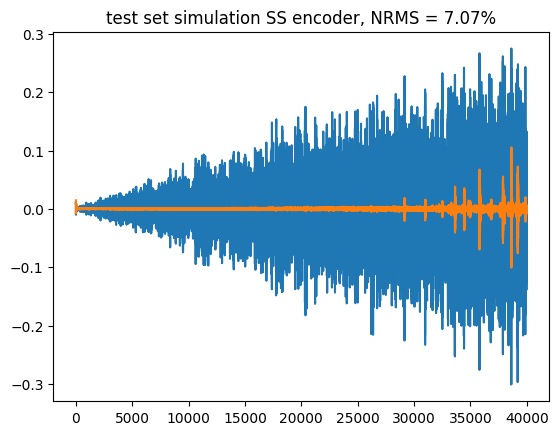

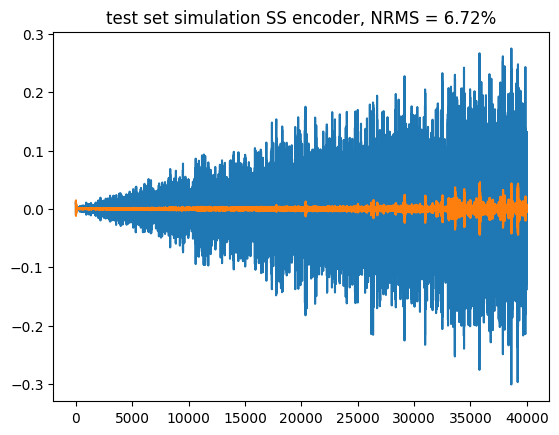

In [27]:
plt.plot(y_true)
plt.plot(y_true[1:] - y_pred[:-1])
plt.title(f'test set simulation SS encoder, NRMS = {pred_err:.2%}')
plt.show()

plt.plot(y_true)
plt.plot(y_true - y_sim)
plt.title(f'test set simulation SS encoder, NRMS = {sim_err:.2%}')
plt.show()